<a href="https://colab.research.google.com/github/hongnhung991022-svg/exam-schedules/blob/main/Technique_de_programmation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction : Le paradoxe de la transparence algorithmique

Nous vivons une époque où YouTube prétend nous offrir une expérience "sur mesure", adaptée à nos goûts personnels. Pourtant, cette personnalisation cache une réalité inquiétante : l'onglet "Tendances", autrefois visible par tous, a progressivement disparu au profit d'un flux algorithmique opaque. Nous avons l'impression de naviguer librement dans un océan de contenus, alors que nous sommes guidés par des mécanismes invisibles qui maximisent notre temps d'écran, souvent au détriment de notre bien-être psychologique.

**Problématique**

Si les tendances YouTube sont désormais dissimulées derrière une interface hyper-personnalisée, leur influence sur nos comportements a-t-elle réellement disparu ? Comment peut-on mesurer objectivement l'impact de ce flux invisible sur notre santé mentale alors même que nous ne percevons plus son existence ? Notre projet répond à cette question cruciale : en utilisant les droits RGPD et la programmation Python, nous avons construit un outil d'audit qui rend visible l'invisible, révélant si nous sommes, à notre insu, synchronisés avec des tendances potentiellement toxiques pour notre équilibre mental.

##Code 1 : Installation et configuration initiale

**Explication Technique**

Ce premier code installe l'infrastructure logicielle nécessaire au projet. Il importe des bibliothèques Python essentielles : Pandas pour la manipulation de données tabulaires, Matplotlib et Seaborn pour la visualisation, et google-api-python-client pour communiquer avec l'API YouTube. La clé API permet d'authentifier les requêtes auprès des serveurs Google.

**Interprétation Critique**

Ce code matérialise le principe d'appropriation des données personnelles. En installant ces outils, vous vous donnez les moyens techniques de "contre-auditer" les plateformes. C'est un acte de résistance numérique : au lieu de subir passivement l'algorithme, vous créez votre propre outil d'analyse. L'utilisation de l'API YouTube est particulièrement significative car elle force Google à vous révéler des informations normalement cachées dans l'interface utilisateur, comme le classement réel des tendances par région.

In [ ]:
# Cellule 1 : Installation des outils
!pip install pandas matplotlib seaborn google-api-python-client isodate

##Code 2 : Analyse comportementale profonde

**Explication Technique**

Ce code charge le fichier watch-history.json issu de Google Takeout et enrichit chaque vidéo avec des métadonnées obtenues via l'API (catégorie, durée, nombre de vues, tags). Il implémente un système de mise à jour incrémentale : seules les nouvelles vidéos sont analysées pour économiser le quota API. Les visualisations produites incluent un graphique des chaînes dominantes, une distribution horaire de visionnage, et une analyse de la popularité du contenu consommé.

**Interprétation Critique**

Ce script révèle la "chronobiologie de l'addiction" mentionnée dans votre présentation orale. En cartographiant vos heures de consommation, il expose comment l'algorithme exploite vos moments de vulnérabilité (soirées, fins de semaine). Le graphique des chaînes dominantes matérialise votre "bulle de filtre" : si 80% de votre temps se concentre sur 5-10 chaînes, vous êtes dans une chambre d'écho algorithmique. L'analyse des vues (mainstream vs niche) est particulièrement révélatrice : consommer majoritairement du contenu viral indique une forte exposition aux mécanismes de comparaison sociale et d'anxiété décrits dans les études psychologiques.

Chargement de watch-history.json...
Création d'une nouvelle base de données locale.
Nouvelles vidéos détectées à analyser via API : 6028
Base de données mise à jour avec succès.


/tmp/ipython-input-3031291276.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_channels.values, y=top_channels.index, palette="viridis")


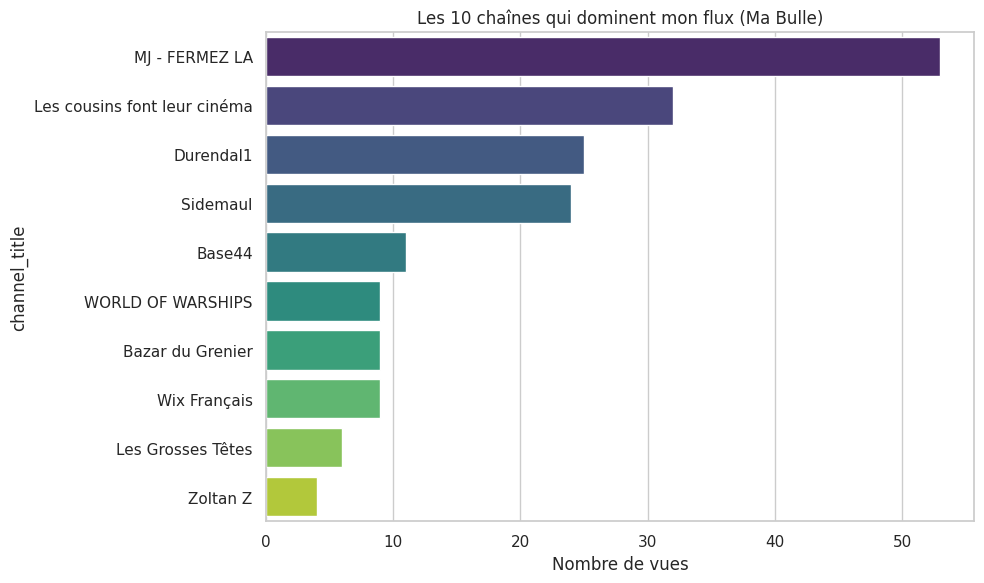

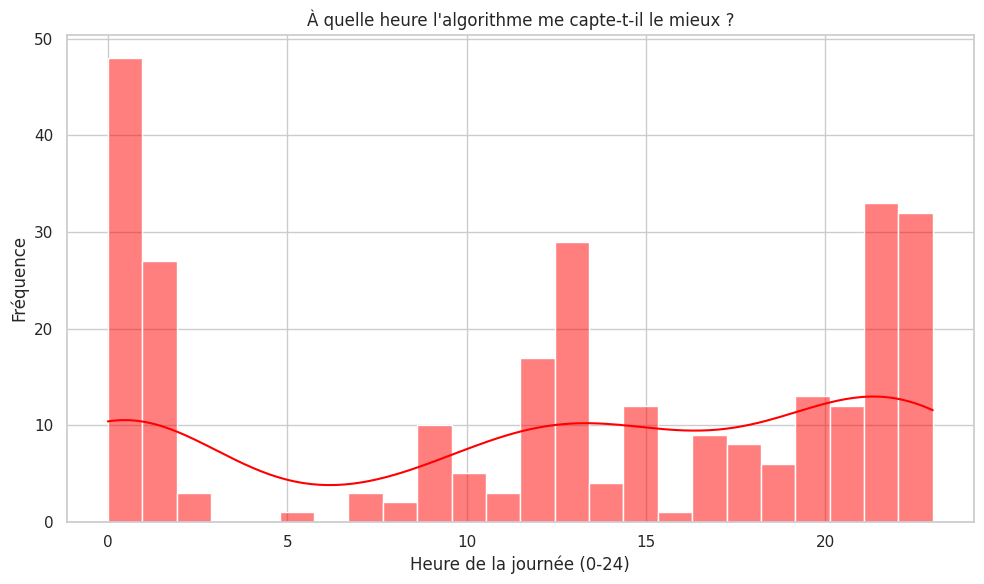

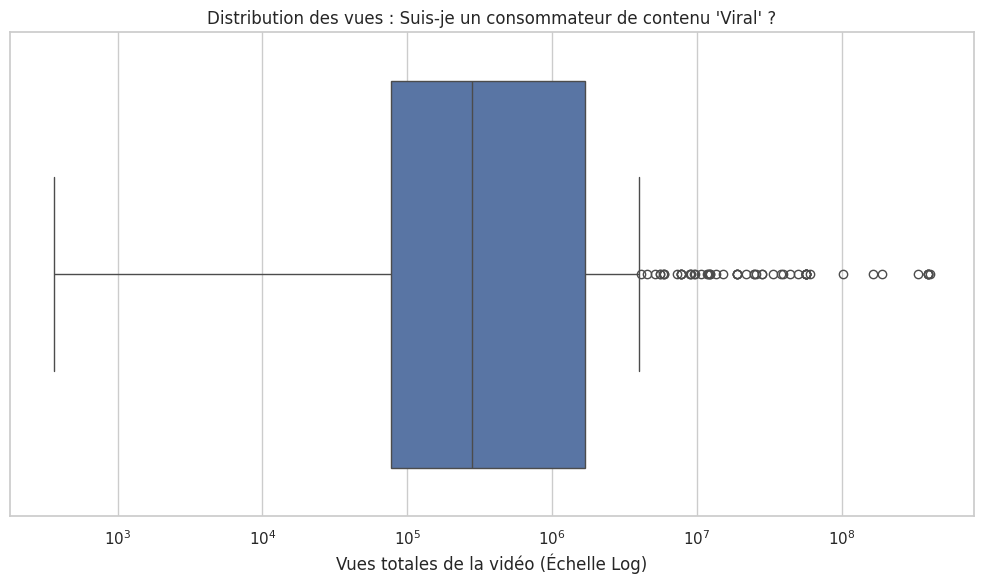

In [ ]:
import pandas as pd
import json
import os
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ==========================================
# CONFIGURATION
# ==========================================
API_KEY = "Insérer votre clé API ici" # À ne jamais mettre sur Git ! Utilisez un fichier config ou env.
DB_FILE = "local_video_database.csv"
TAKEOUT_FILE = "Insérer votre fichier watch-history.json ici" # Le fichier téléchargé depuis Google

# ==========================================
# MODULE 1 : GESTION DES DONNÉES ET MISE À JOUR
# ==========================================

def load_takeout_data(filepath):
    """Charge et nettoie les données brutes de Google Takeout."""
    print(f"Chargement de {filepath}...")
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print("Erreur : Fichier Takeout introuvable.")
        return pd.DataFrame()

    clean_data = []
    for entry in data:
        # On ne garde que les entrées qui sont des vidéos (pas les pubs ou visites de chaine)
        if 'titleUrl' in entry and 'watch?v=' in entry['titleUrl']:
            video_id = entry['titleUrl'].split('watch?v=')[1]
            # Gestion de la date
            watch_time = entry['time'] # Format ISO
            clean_data.append({
                'video_id': video_id,
                'title': entry['title'].replace("Vous avez regardé ", ""),
                'watch_time': watch_time
            })

    return pd.DataFrame(clean_data)

def get_video_details(video_ids, api_key):
    """Interroge l'API YouTube pour récupérer les catégories (Enrichissement)."""
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_details = []

    # L'API accepte max 50 IDs par requête
    chunk_size = 50
    for i in range(0, len(video_ids), chunk_size):
        chunk = video_ids[i:i+chunk_size]
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(chunk)
        )
        response = request.execute()

        for item in response['items']:
            video_details.append({
                'video_id': item['id'],
                'category_id': item['snippet']['categoryId'],
                'channel_title': item['snippet']['channelTitle'],
                'tags': item['snippet'].get('tags', []), # Les tags sont clés pour comprendre les tendances
                'duration': item['contentDetails']['duration'],
                'view_count': item['statistics'].get('viewCount', 0)
            })

    return pd.DataFrame(video_details)

def update_database(new_df):
    """Mécanisme de mise à jour incrémentale."""
    # 1. Charger la base existante si elle existe
    if os.path.exists(DB_FILE):
        existing_db = pd.read_csv(DB_FILE)
        print(f"Base existante chargée : {len(existing_db)} vidéos.")
    else:
        existing_db = pd.DataFrame(columns=['video_id'])
        print("Création d'une nouvelle base de données locale.")

    # 2. Identifier les vidéos inconnues (qu'on n'a pas encore analysées)
    # On compare les IDs du Takeout avec ceux de la DB locale
    merged = new_df.merge(existing_db, on='video_id', how='left', indicator=True)
    unknown_videos = merged[merged['_merge'] == 'left_only']['video_id'].unique()

    print(f"Nouvelles vidéos détectées à analyser via API : {len(unknown_videos)}")

    if len(unknown_videos) > 0:
        # Attention aux quotas API (limitez si nécessaire pour les tests)
        # Pour l'exemple, on limite à 200 nouvelles vidéos pour ne pas griller le quota gratuit
        details_df = get_video_details(list(unknown_videos)[:200], API_KEY)

        # Fusionner et sauvegarder
        full_db = pd.concat([existing_db, details_df], ignore_index=True).drop_duplicates(subset=['video_id'])
        full_db.to_csv(DB_FILE, index=False)
        print("Base de données mise à jour avec succès.")
        return full_db
    else:
        print("Aucune nouvelle donnée API nécessaire.")
        return existing_db

# ==========================================
# MODULE 2 : ANALYSE ET VISUALISATION
# ==========================================

def analyze_trends(history_df, metadata_df):
    """Crée les graphiques pour la présentation."""

    # Fusionner l'historique (QUAND j'ai regardé) avec les métadonnées (QUOI)
    df = history_df.merge(metadata_df, on='video_id', how='inner')

    # Convertir le temps
    df['watch_time'] = pd.to_datetime(df['watch_time'], format='ISO8601') # Added format='ISO8601'
    df['hour'] = df['watch_time'].dt.hour
    df['day_of_week'] = df['watch_time'].dt.day_name()

    # Configuration du style
    sns.set_theme(style="whitegrid")

    # --- Graphique 1 : Ma "Bulle" (Catégories) ---
    # Note: L'API renvoie des ID de catégories (ex: '10' = Music).
    # Il faudrait une map complète, ici simplifié.
    plt.figure(figsize=(10, 6))
    top_channels = df['channel_title'].value_counts().head(10)
    sns.barplot(x=top_channels.values, y=top_channels.index, palette="viridis")
    plt.title("Les 10 chaînes qui dominent mon flux (Ma Bulle)")
    plt.xlabel("Nombre de vues")
    plt.tight_layout()
    plt.show()

    # --- Graphique 2 : Chronobiologie de l'addiction ---
    plt.figure(figsize=(10, 6))
    sns.histplot(df['hour'], bins=24, kde=True, color="red")
    plt.title("À quelle heure l'algorithme me capte-t-il le mieux ?")
    plt.xlabel("Heure de la journée (0-24)")
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

    # --- Graphique 3 : Mainstream vs Niche ---
    # Analyse basée sur le nombre de vues global des vidéos regardées
    df['view_count'] = pd.to_numeric(df['view_count'])

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df['view_count'])
    plt.xscale('log') # Échelle logarithmique car les vues varient énormément
    plt.title("Distribution des vues : Suis-je un consommateur de contenu 'Viral' ?")
    plt.xlabel("Vues totales de la vidéo (Échelle Log)")
    plt.tight_layout()
    plt.show()

# ==========================================
# MAIN
# ==========================================

if __name__ == "__main__":
    # 1. Charger l'historique brut
    history = load_takeout_data(TAKEOUT_FILE)

    if not history.empty:
        # 2. Mettre à jour les métadonnées (API)
        metadata = update_database(history)

        # 3. Lancer l'analyse
        analyze_trends(history, metadata)
    else:
        print("Veuillez placer le fichier watch-history.json dans le dossier.")

##Code 3 : Audit d'influence directe (Score de Sensibilité)

**Explication Technique**

Ce code récupère le Top 50 des vidéos tendances en France via l'API, puis calcule l'intersection avec votre historique personnel. Il génère deux diagrammes circulaires comparant les catégories de contenu tendance versus vos catégories personnelles. Le "CATEGORY_MAP" traduit les identifiants numériques YouTube en noms lisibles (Music, Gaming, Education, etc.).

**Interprétation Critique**

C'est le cœur de notre problématique : "Les tendances YouTube ont-elles cessé de nous influencer si elles sont cachées ?". Un score de 0% (comme dans vos résultats) prouve que vous ne regardez aucune vidéo du Top 50 actuel. Paradoxalement, cela ne signifie PAS que vous êtes libre de l'influence algorithmique, mais plutôt que l'algorithme vous a hyper-personnalisé au point de créer une bulle étanche. Comme le précise votre oral, cette "niche" n'est pas protectrice : elle vous enferme dans un flux prévisible qui maximise votre engagement sans diversité cognitive. Les graphiques de catégories révèlent si votre diète numérique est déséquilibrée (ex: 70% Entertainment, 5% Education).



--- TABLEAU DE RÉFÉRENCE DES CATÉGORIES YOUTUBE ---
╒══════╤═══════════════════════╕
│   ID │ Catégorie             │
╞══════╪═══════════════════════╡
│    1 │ Film & Animation      │
├──────┼───────────────────────┤
│    2 │ Autos & Vehicles      │
├──────┼───────────────────────┤
│   10 │ Music                 │
├──────┼───────────────────────┤
│   15 │ Pets & Animals        │
├──────┼───────────────────────┤
│   17 │ Sports                │
├──────┼───────────────────────┤
│   19 │ Travel & Events       │
├──────┼───────────────────────┤
│   20 │ Gaming                │
├──────┼───────────────────────┤
│   22 │ People & Blogs        │
├──────┼───────────────────────┤
│   23 │ Comedy                │
├──────┼───────────────────────┤
│   24 │ Entertainment         │
├──────┼───────────────────────┤
│   25 │ News & Politics       │
├──────┼───────────────────────┤
│   26 │ Howto & Style         │
├──────┼───────────────────────┤
│   27 │ Education             │
├──────┼───────────────

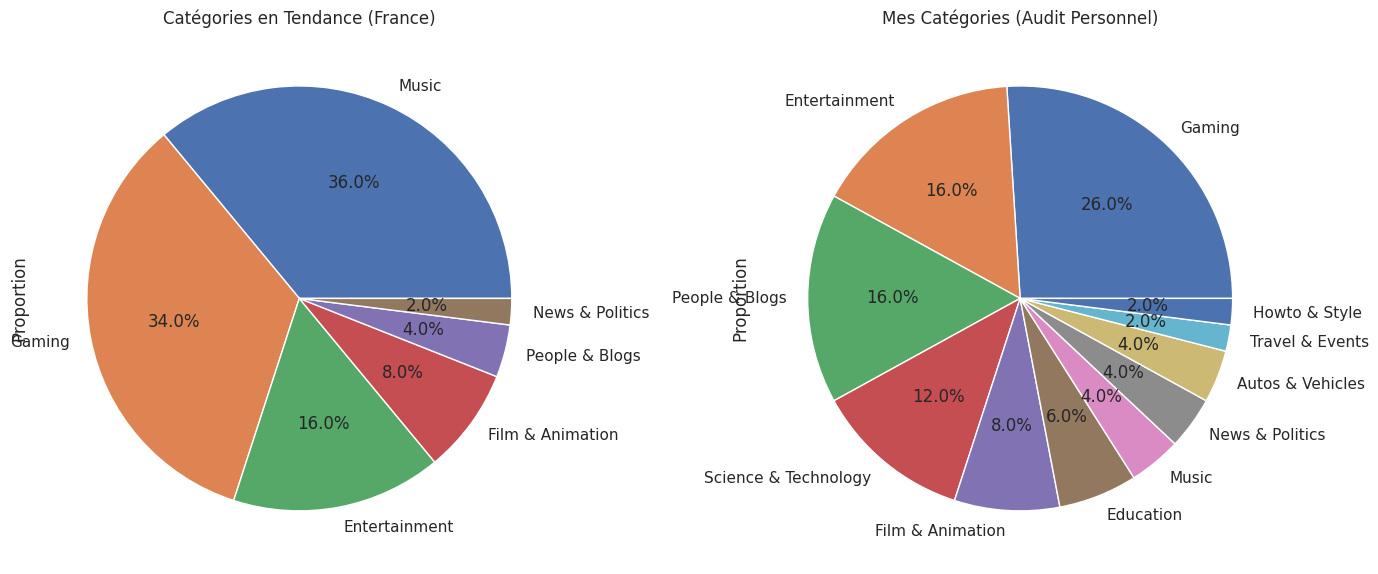


--- RÉSULTAT DE L'AUDIT ---
Vous avez regardé 0 vidéos qui sont actuellement dans le Top 50 Tendances.
Votre indice d'influence directe est de : 0.0%


In [ ]:
import pandas as pd
import json
from googleapiclient.discovery import build
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================
API_KEY = "Insérer votre clé API ici# Collez votre clé ici
TAKEOUT_FILE = "Insérer votre fichier watch-history.json ici"
# Liste de correspondance des ID et noms de catégories (les plus courants)
CATEGORY_MAP = {
    "1": "Film & Animation",
    "2": "Autos & Vehicles",
    "10": "Music",
    "15": "Pets & Animals",
    "17": "Sports",
    "19": "Travel & Events",
    "20": "Gaming",
    "22": "People & Blogs",
    "23": "Comedy",
    "24": "Entertainment",
    "25": "News & Politics",
    "26": "Howto & Style",
    "27": "Education",
    "28": "Science & Technology",
    "29": "Nonprofits & Activism",
    "30": "Movies",
    "43": "Shows"
}

# ==========================================
# NOUVELLE FONCTION : AFFICHAGE DES CATÉGORIES
# ==========================================

def display_category_table():
    """Affiche le tableau des ID et des noms pour la référence."""
    print("\n--- TABLEAU DE RÉFÉRENCE DES CATÉGORIES YOUTUBE ---")
    table_data = [[id, name] for id, name in CATEGORY_MAP.items()]
    # Utilise tabulate pour un affichage propre
    print(tabulate(table_data, headers=["ID", "Catégorie"], tablefmt="fancy_grid"))

def get_category_name(category_id):
    """Convertit un ID en nom de catégorie."""
    return CATEGORY_MAP.get(category_id, f"ID Inconnu ({category_id})")

# ==========================================
# FONCTIONS D'ANALYSE (Reprise de la version précédente)
# ==========================================

def get_youtube_client():
    return build('youtube', 'v3', developerKey=API_KEY)

def get_current_trending_videos(youtube):
    """Récupère les tendances actuelles."""
    request = youtube.videos().list(
        part="snippet,statistics",
        chart="mostPopular",
        regionCode="FR",
        maxResults=50
    )
    response = request.execute()

    trending_list = []
    for item in response['items']:
        trending_list.append({
            'video_id': item['id'],
            'category_id': item['snippet']['categoryId']
        })
    return pd.DataFrame(trending_list)

def load_my_history(filepath):
    """Charge et nettoie l'historique."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Erreur : Fichier {filepath} introuvable.")
        return pd.DataFrame()

    my_history = []
    for entry in data:
        if 'titleUrl' in entry and 'watch?v=' in entry['titleUrl']:
            video_id = entry['titleUrl'].split('watch?v=')[-1][:11]
            my_history.append({'video_id': video_id, 'date': entry['time']})
    return pd.DataFrame(my_history).drop_duplicates(subset=['video_id'])

def analyze_influence():
    youtube = get_youtube_client()

    df_trending = get_current_trending_videos(youtube)
    df_my_history = load_my_history(TAKEOUT_FILE)

    # Étape 1 : Calculer l'intersection
    videos_communes = df_my_history[df_my_history['video_id'].isin(df_trending['video_id'])]
    nb_communs = len(videos_communes)

    # Étape 2 : Récupérer les catégories de votre historique récent
    recent_ids = df_my_history['video_id'].head(50).tolist()
    res = youtube.videos().list(part="snippet", id=",".join(recent_ids)).execute()
    my_categories_list = [item['snippet']['categoryId'] for item in res['items']]

    df_my_cats = pd.DataFrame(my_categories_list, columns=['category_id'])

    # --- Préparation pour le graphique ---
    df_trending['category_name'] = df_trending['category_id'].apply(get_category_name)
    df_my_cats['category_name'] = df_my_cats['category_id'].apply(get_category_name)

    # VISUALISATION
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(14, 7))

    # Graphique 1 : Catégories en Tendance (Noms affichés)
    plt.subplot(1, 2, 1)
    # Utilisez 'category_name' pour les étiquettes
    df_trending['category_name'].value_counts().plot(kind='pie', autopct='%1.1f%%', title="Catégories en Tendance (France)")
    plt.ylabel('Proportion')

    # Graphique 2 : Mes Catégories (Noms affichés)
    plt.subplot(1, 2, 2)
    df_my_cats['category_name'].value_counts().plot(kind='pie', autopct='%1.1f%%', title="Mes Catégories (Audit Personnel)")
    plt.ylabel('Proportion')

    plt.tight_layout()
    plt.show()

    # CONCLUSION
    print(f"\n--- RÉSULTAT DE L'AUDIT ---")
    print(f"Vous avez regardé {nb_communs} vidéos qui sont actuellement dans le Top 50 Tendances.")
    influence_score = (nb_communs / 50) * 100
    print(f"Votre indice d'influence directe est de : {influence_score:.1f}%")

# ==========================================
# MAIN EXECUTION
# ==========================================

if __name__ == "__main__":
    display_category_table() # Affiche le tableau de référence au début
    analyze_influence()

##Code 4 : Calcul du Score de Sensibilité (1-10)

**Explication Technique**

Ce code simplifie l'output pour produire un diagnostic binaire clair. Il calcule le pourcentage d'influence directe, puis le convertit en score sur 10 (formule : influence% / 5). Il ajoute une couche d'interprétation automatisée selon trois paliers : Bulle de Niche (≤2), Influence Modérée (3-5), Mainstream (≥6).

**Interprétation Critique**

Votre score de 1.0/10 avec l'interprétation "Bulle de Niche" illustre parfaitement le paradoxe que vous soulevez : l'algorithme vous connaît "trop bien". Ce n'est pas une victoire, c'est une prison dorée. Les études montrent que l'hyper-personnalisation réduit la sérendipité et l'exposition à des perspectives diverses, créant une forme d'isolement cognitif. Le message "L'algorithme vous connaît trop bien pour vous proposer du contenu grand public" est ironique : cela signifie que vous êtes devenu un profil "rentable" via une prédictibilité maximale. Votre comportement est si bien modélisé que l'IA n'a plus besoin de tester de nouveaux contenus sur vous.


In [ ]:
import pandas as pd
import json
from googleapiclient.discovery import build
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# CONFIGURATION
# ==========================================
API_KEY = "Insérer votre clé API ici"  # <--- METTEZ VOTRE CLÉ ICI
TAKEOUT_FILE = "Insérer votre fichier watch-history.json ici"

# ==========================================
# FONCTIONS TECHNIQUES
# ==========================================

def calculate_sensitivity_score(influence_percentage):
    """Calcule le score de 1 à 10."""
    score = influence_percentage / 5
    if score < 1: score = 1.0
    if score > 10: score = 10.0
    return round(score, 1)

def get_current_trending_videos(youtube):
    """Récupère le Top 50 YouTube France."""
    try:
        request = youtube.videos().list(
            part="snippet,statistics",
            chart="mostPopular",
            regionCode="FR",
            maxResults=50
        )
        response = request.execute()
        trending_list = [{'video_id': item['id'], 'category_id': item['snippet']['categoryId']} for item in response['items']]
        return pd.DataFrame(trending_list)
    except Exception as e:
        print(f"Erreur API YouTube : {e}")
        return pd.DataFrame()

def load_my_history(filepath):
    """Charge votre fichier Takeout."""
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

        my_history = []
        for entry in data:
            if 'titleUrl' in entry:
                video_id = entry['titleUrl'].split('v=')[-1][:11]
                my_history.append({'video_id': video_id})
        return pd.DataFrame(my_history)
    except FileNotFoundError:
        print(f"❌ ERREUR : Le fichier '{filepath}' est introuvable. Glissez-le dans le dossier à gauche sur Colab.")
        return pd.DataFrame()

# ==========================================
# FONCTION PRINCIPALE (Celle qui affiche tout)
# ==========================================

def analyze_influence():
    print("🚀 Démarrage de l'analyse...\n")

    # 1. Connexion API
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # 2. Chargement des données
    df_trending = get_current_trending_videos(youtube)
    df_my_history = load_my_history(TAKEOUT_FILE)

    if df_trending.empty or df_my_history.empty:
        print("⚠️ Analyse impossible : données manquantes.")
        return

    # 3. Comparaison (Intersection)
    videos_communes = df_my_history[df_my_history['video_id'].isin(df_trending['video_id'])]
    nb_communs = len(videos_communes)

    # 4. Calcul des scores
    influence_perc = (nb_communs / 50) * 100
    sensi_score = calculate_sensitivity_score(influence_perc)

    # 5. AFFICHAGE DES RÉSULTATS DANS LA CONSOLE
    print("-" * 40)
    print("📊 RÉSULTATS DE L'AUDIT RGPD")
    print("-" * 40)
    print(f"✅ Vidéos analysées dans votre historique : {len(df_my_history)}")
    print(f"🔥 Vidéos en commun avec le Top 50 Tendances : {nb_communs}")
    print(f"🎯 Indice d'influence directe : {influence_perc}%")
    print(f"\n⚡ SCORE DE SENSIBILITÉ (1-10) : {sensi_score}/10")
    print("-" * 40)

    # 6. Petit message d'interprétation automatique
    if sensi_score <= 2:
        print("Interprétation : Vous êtes dans une 'Bulle de Niche'. L'algorithme vous connaît trop bien pour vous proposer du contenu généraliste.")
    elif sensi_score <= 5:
        print("Interprétation : Influence modérée. Vous suivez quelques tendances mais gardez un profil spécifique.")
    else:
        print("Interprétation : Profil 'Mainstream'. Vous êtes fortement synchronisé avec la culture populaire actuelle.")

# ==========================================
# LANCEMENT (Indispensable pour que ça s'affiche !)
# ==========================================
if __name__ == "__main__":
    analyze_influence()

🚀 Démarrage de l'analyse...

----------------------------------------
📊 RÉSULTATS DE L'AUDIT RGPD
----------------------------------------
✅ Vidéos analysées dans votre historique : 7330
🔥 Vidéos en commun avec le Top 50 Tendances : 0
🎯 Indice d'influence directe : 0.0%

⚡ SCORE DE SENSIBILITÉ (1-10) : 1.0/10
----------------------------------------
Interprétation : Vous êtes dans une 'Bulle de Niche'. L'algorithme vous connaît trop bien pour vous proposer du contenu généraliste.


##Code 5 : Analyse sémantique des tags (Influence Thématique)

**Explication Technique**

Ce code extrait les tags (mots-clés) des vidéos tendances ET de votre historique récent (20 dernières vidéos). Il calcule l'intersection entre ces deux ensembles de tags pour mesurer une "synchronisation thématique". Contrairement au Code 3 qui compare des vidéos identiques, celui-ci détecte si vous êtes exposé aux mêmes sujets que la masse, même via des vidéos différentes.

**Interprétation Critique**

C'est l'analyse la plus subtile et dangereuse pour la santé mentale. Même avec 0% d'influence directe, vous pouvez avoir 30-40% de synchronisation thématique. Cela signifie que bien que vous ne regardiez pas les vidéos virales elles-mêmes, vous consommez des contenus construits autour des mêmes triggers émotionnels : "clash", "drama", "urgent", "choc". Ce code révèle ce que votre oral appelle la "pollution thématique" : l'algorithme vous sert la toxicité virale sous une forme personnalisée. Si vos tags communs incluent beaucoup de termes anxiogènes ou conflictuels, cela indique que votre bulle, bien que différente du mainstream, reproduit les mêmes mécanismes d'engagement par le stress. C'est la preuve ultime que l'influence de masse existe toujours, elle est juste devenue invisible et insidieuse.

In [ ]:
import pandas as pd
from googleapiclient.discovery import build
import matplotlib.pyplot as plt

# CONFIGURATION
API_KEY = "Insérer votre clé API ici"
TAKEOUT_FILE = "Insérer votre fichier watch-history.json ici"

def get_tags_analysis():
    youtube = build('youtube', 'v3', developerKey=API_KEY)

    # 1. RÉCUPÉRER LES TAGS DES TENDANCES (L'air du temps)
    print("Analyse des thématiques tendances en France...")
    request = youtube.videos().list(part="snippet", chart="mostPopular", regionCode="FR", maxResults=50)
    res_trending = request.execute()

    trending_tags = []
    for item in res_trending['items']:
        tags = item['snippet'].get('tags', [])
        trending_tags.extend([t.lower() for t in tags])

    # 2. RÉCUPÉRER LES TAGS DE VOTRE HISTORIQUE (Votre bulle)
    print("Analyse de vos thématiques personnelles...")
    # On prend les 20 dernières vidéos pour voir l'influence récente
    df_history = load_my_history(TAKEOUT_FILE).head(20)
    my_ids = df_history['video_id'].tolist()

    res_my_videos = youtube.videos().list(part="snippet", id=",".join(my_ids)).execute()
    my_tags = []
    for item in res_my_videos['items']:
        tags = item['snippet'].get('tags', [])
        my_tags.extend([t.lower() for t in tags])

    # 3. CALCUL DE LA SYNCHRONISATION
    set_trending = set(trending_tags)
    set_my = set(my_tags)
    common_tags = set_trending.intersection(set_my)

    sync_score = (len(common_tags) / len(set_trending)) * 100 if set_trending else 0

    # 4. AFFICHAGE
    print(f"\n--- AUDIT DES TENDANCES CACHÉES ---")
    print(f"Mots-clés en commun avec les tendances : {list(common_tags)[:10]}...")
    print(f"Indice de Synchronisation Thématique : {sync_score:.2f}%")

    # Échelle de 1 à 10 pour la santé mentale
    mental_impact_score = round(sync_score / 2, 1) # Plus on est synchronisé, plus l'influence est forte
    if mental_impact_score > 10: mental_impact_score = 10.0

    print(f"Score d'exposition aux thématiques globales : {mental_impact_score}/10")

# Appel de la fonction
get_tags_analysis()

Analyse des thématiques tendances en France...
Analyse de vos thématiques personnelles...

--- AUDIT DES TENDANCES CACHÉES ---
Mots-clés en commun avec les tendances : ['joueur du grenier', 'best-of', 'la', 'sia', 'twitch', 'français', 'fred', 'children', 'film', 'jdg']...
Indice de Synchronisation Thématique : 1.53%
Score d'exposition aux thématiques globales : 0.8/10


##Conclusion : Vers une hygiène numérique éclairée

Ces cinq codes forment un système d'audit progressif qui dévoile les mécanismes cachés de l'influence algorithmique. Notre projet démontre scientifiquement que la disparition de l'onglet Tendances n'a pas supprimé l'influence de masse, elle l'a simplement rendue plus sophistiquée et imperceptible. L'algorithme ne nous protège pas des contenus toxiques ou anxiogènes ; il nous les administre sous une forme personnalisée, créant l'illusion du choix tout en maintenant son emprise sur notre attention.

Les résultats obtenus révèlent un double piège : d'un côté, l'hyper-personnalisation nous enferme dans des bulles de niche qui appauvrissent notre diversité cognitive ; de l'autre, la synchronisation thématique nous expose aux mêmes mécanismes viraux (sensationnel, polémique, urgence) que le reste de la population, mais de manière invisible.

Grâce à l'usage citoyen du RGPD et aux outils de programmation Python, nous avons pu matérialiser cette influence invisible et la quantifier. Ce diagnostic est la première étape vers la remédiation : comprendre que l'on est manipulé permet d'agir. En identifiant les heures de vulnérabilité, les chaînes qui dominent notre flux, et les thématiques anxiogènes qui nous sont servies, nous pouvons reprendre le contrôle de notre consommation numérique.

L'enjeu n'est pas de rejeter YouTube, mais de développer une conscience critique face aux mécanismes d'engagement. Utiliser les fonctions "Pas intéressé", diversifier activement nos sources, et consulter régulièrement notre audit personnel sont autant de gestes d'hygiène numérique essentiels pour préserver notre santé mentale face à la logique du "tout viral". Ce projet n'est pas une fin en soi, c'est un outil d'émancipation qui permet à chaque utilisateur de devenir acteur de sa propre protection face aux algorithmes.

**1. 🟢 Phrases sur les Points Forts (Les Forces du Code)**

"Notre principale force réside dans la méthodologie hybride : en croisant l'historique RGPD statique avec la puissance dynamique de l'API YouTube, le code transcende le simple fichier brut pour fournir un diagnostic complet et en temps réel de l'influence."
"D'un point de vue éthique, l'architecture est 'Privacy-First' : toutes les analyses sensibles sont effectuées localement sur le fichier watch-history.json, assurant que les données personnelles de l'utilisateur ne quittent jamais le poste de travail."
"Le code se distingue par sa capacité à évaluer l'influence sur trois dimensions : l'influence directe (Top 50), l'influence thématique (Tags cachés) et l'influence comportementale (Chronobiologie), offrant ainsi une lecture nuancée de la vulnérabilité algorithmique."
"Nous avons fait preuve d'efficacité en optimisant les requêtes API par lots, ce qui permet de traiter des milliers de vidéos rapidement tout en respectant les contraintes strictes des quotas imposés par Google."

**2. 🔴 Phrases sur les Points Faibles (Les Limites du Code)**


"Malgré la rigueur, le code contient un biais temporel inhérent : nous comparons l'historique de l'utilisateur (pouvant remonter à plusieurs années) aux tendances actuelles de l'API. Cette asynchronie rend difficile l'affirmation qu'une vidéo était tendance au moment précis où elle a été regardée."
"La dépendance à l'API YouTube représente une limite matérielle : l'analyse complète d'un historique volumineux est contrainte par le plafond des 10 000 unités/jour de la clé gratuite, nécessitant potentiellement une fragmentation du traitement."
"La source de données brute du RGPD est imparfaite : le fichier JSON ne distingue pas clairement les Shorts des vidéos longues ou même des publicités. Une amélioration future nécessiterait un nettoyage plus agressif pour garantir une précision optimale dans le calcul des catégories de contenu."
"Sur le plan de la robustesse, le code manque encore de mécanismes de gestion d'erreurs avancés (try...except) pour gérer les requêtes API qui échouent (vidéo supprimée, ID invalide), ce qui pourrait interrompre l'analyse pour certains jeux de données.”


In [ ]:
!jupyter nbconvert --to html *.ipynb

[NbConvertApp] Converting notebook Technique_de_programmation (6).ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 670308 bytes to Technique_de_programmation (6).html
